In [1]:
import numpy as np
import pandas as pd
import yfinance as yf 
import matplotlib.pyplot as plt

# Example 3.6 - Pair Trading of GLD and GDX

* GLD = spot price of gold
* GDX = basket of gold-mining stocks
* When the spread between them is large, we will bet on convergence
* This is like betting on the mean reversion of the *synthetic* GLD/GDX
  * If spread is positive, short GLD/GDX
  * If spread is negative, long GLD/GDX
* Book dates are 5/23/2006 to 11/30/2007 - obviously, a long time ago!
  * We'll stick with these first to reproduce, but then re-do with a longer period of performance

In [2]:
start='2006-05-23'
end='2007-11-30'

df = yf.download(['GLD','GDX'], start=start, end=end)['Adj Close'].dropna()
df

[*********************100%***********************]  2 of 2 completed


Ticker,GDX,GLD
Date,,
2006-05-23 00:00:00+00:00,32.828873,66.379997
2006-05-24 00:00:00+00:00,31.583519,64.059998
2006-05-25 00:00:00+00:00,33.140213,64.699997
2006-05-26 00:00:00+00:00,33.339123,65.099998
2006-05-30 00:00:00+00:00,33.010479,65.110001
...,...,...
2007-11-23 00:00:00+00:00,42.369644,81.250000
2007-11-26 00:00:00+00:00,40.817104,81.300003
2007-11-27 00:00:00+00:00,40.426800,80.099998


In [3]:
import statsmodels.api as sm

trainset = np.arange(0, 252)
testset = np.arange(trainset.shape[0], df.shape[0])

x_train = df['GDX'].iloc[trainset]
y_train = df['GLD'].iloc[trainset]

model = sm.OLS(y_train, x_train)
results = model.fit() 

hedgeRatio = results.params 
hedgeRatio

GDX    1.880467
dtype: float64

In [4]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    GLD   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.619e+05
Date:                Tue, 19 Nov 2024   Prob (F-statistic):                        0.00
Time:                        18:40:05   Log-Likelihood:                         -525.35
No. Observations:                 252   AIC:                                      1053.
Df Residuals:                     251   BIC:                                      1056.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
GDX            1.8805      0.004    511.746      0.000       1.873       1.888
==============================================================================
Omnibus:                        5.723   Durbin-Watson:                   0.184
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                5.773
Skew:                          -0.370   Prob(JB):                       0.0558
Kurtosis:                       2.947   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/var/folders/k_/3s9bjxk17ss2bty8k9tjwjrc0000gn/T/ipykernel_19763/4159037493.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_line = hedgeRatio[0] * x_line
/var/folders/k_/3s9bjxk17ss2bty8k9tjwjrc0000gn/T/ipykernel_19763/4159037493.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  equation = f'y = {hedgeRatio[0]:.4f}x'


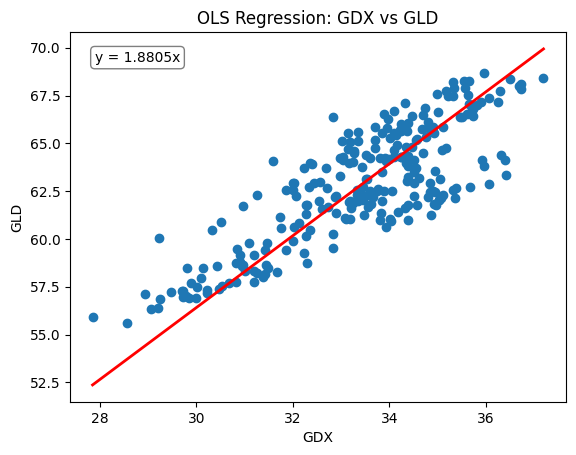

In [5]:
plt.scatter(x_train, y_train)

x_line = np.linspace(x_train.min(), x_train.max(), 100)
y_line = hedgeRatio[0] * x_line

# Plot the regression line
plt.plot(x_line, y_line, color='r', lw=2)

# Add labels and title
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.title('OLS Regression: GDX vs GLD')

# Add text box with regression equation
equation = f'y = {hedgeRatio[0]:.4f}x'
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# Set axes to start from 0
plt.show()

/var/folders/k_/3s9bjxk17ss2bty8k9tjwjrc0000gn/T/ipykernel_19763/2059488966.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  spread = df['GLD'] - hedgeRatio[0] * df['GDX']


np.float64(0.052229540984358225)

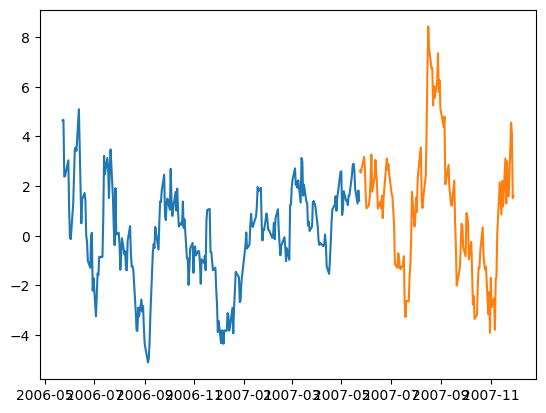

In [6]:
spread = df['GLD'] - hedgeRatio[0] * df['GDX']

plt.plot(spread.iloc[trainset]) 
plt.plot(spread.iloc[testset]) 

spreadMean = np.mean(spread.iloc[trainset])
spreadMean # Book value: 0.05219

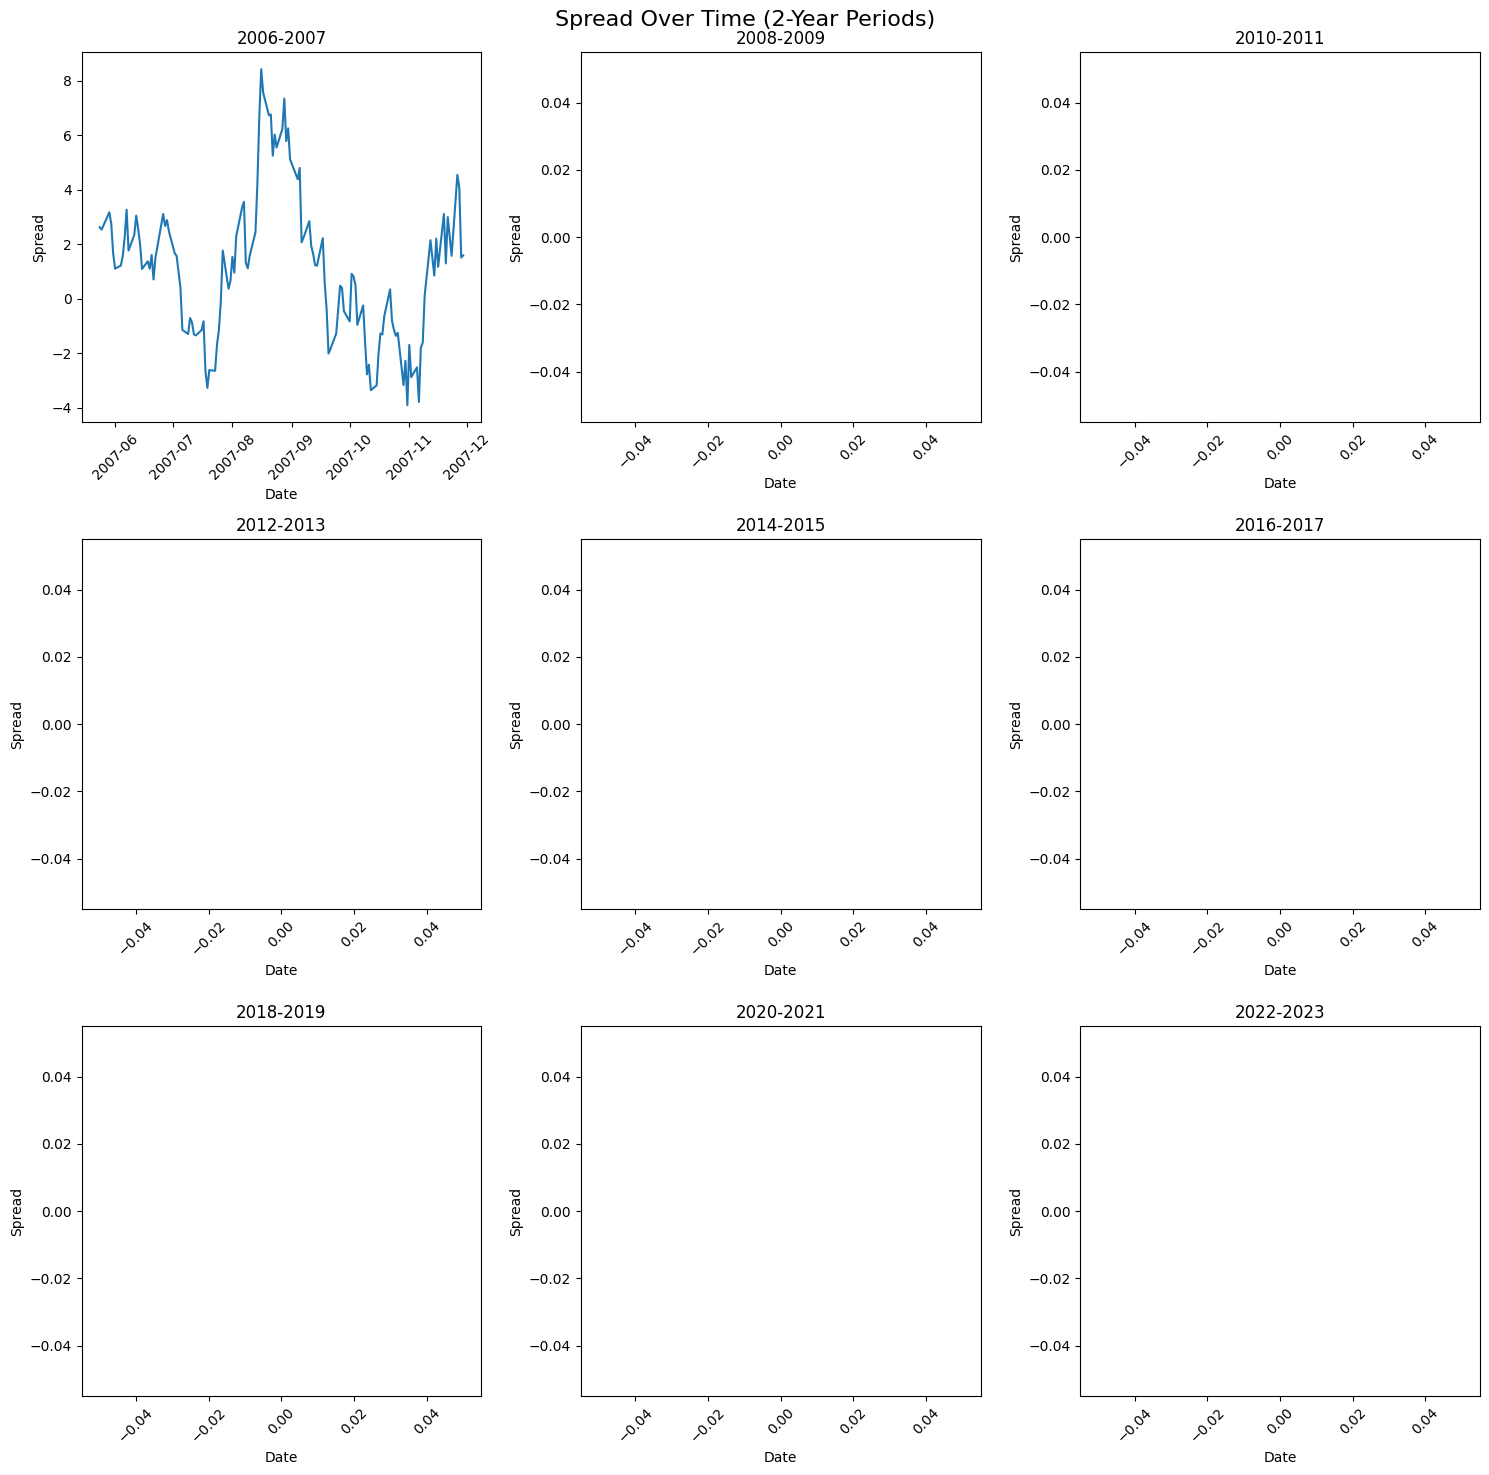

In [7]:
def plot_spreads_grid(spread, testset):
    # Define the date ranges
    start_years = range(2006, 2024, 2)
    n_plots = len(start_years)
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = int(np.ceil(n_plots / n_cols))
    
    # Create the figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Spread Over Time (2-Year Periods)', fontsize=16)
    
    # Flatten the axes array for easier indexing
    axes = axes.flatten()
    
    for i, year in enumerate(start_years):
        start_date = f"{year}-01-01"
        end_date = f"{year+2}-01-01"
        
        # Plot the spread for the current 2-year period
        axes[i].plot(spread.iloc[testset].loc[start_date:end_date])
        
        # Set title and labels
        axes[i].set_title(f"{year}-{year+1}")
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Spread')
        
        # Rotate x-axis labels for better readability
        axes[i].tick_params(axis='x', rotation=45)
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

# Call the function to create the grid of plots
plot_spreads_grid(spread, testset)

In [8]:
spreadStd = np.std(spread.iloc[trainset])
spreadStd # Book value: 1.94486

np.float64(1.9452831550323577)

In [17]:
df

Ticker,GDX,GLD,zscore,positions_GLD_Long,positions_GDX_Long,positions_GLD_Short,positions_GDX_Short,positions_ GDX_Long
Date,,,,,,,,
2006-05-23 00:00:00+00:00,32.828873,66.379997,2.361686,0,0,-1,1,0.0
2006-05-24 00:00:00+00:00,31.583519,64.059998,2.372917,0,0,-1,1,0.0
2006-05-25 00:00:00+00:00,33.140213,64.699997,1.197092,0,0,0,0,0.0
2006-05-26 00:00:00+00:00,33.339123,65.099998,1.210436,0,0,0,0,0.0
2006-05-30 00:00:00+00:00,33.010479,65.110001,1.533272,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...
2007-11-23 00:00:00+00:00,42.369644,81.250000,0.782942,0,0,0,0,0.0
2007-11-26 00:00:00+00:00,40.817104,81.300003,2.309456,0,0,-1,1,0.0
2007-11-27 00:00:00+00:00,40.426800,80.099998,2.069877,0,0,-1,1,0.0


In [9]:
df['zscore'] = (spread - spreadMean) / spreadStd 

df['positions_GLD_Long'] = 0
df['positions_GDX_Long'] = 0
df['positions_GLD_Short'] = 0
df['positions_GDX_Short'] = 0

In [10]:
# Recall, we are trading the "synthetic pair" GLD/GDX and betting on its mean reversion

df.loc[df.zscore >= 2, ('positions_GLD_Short', 'positions_GDX_Short')] = [-1, 1] # Short spread
df.loc[df.zscore <= -2, ('positions_GLD_Long', 'positions_GDX_Long')] = [1, -1] # Buy spread
df.loc[df.zscore <= 1, ('positions_GLD_Short', 'positions_GDX_Short')] = 0 # Exit short spread
df.loc[df.zscore >= -1, ('positions_GLD_Long', 'positions_ GDX_Long')] = 0 # Exit long spread

df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal

df

/var/folders/k_/3s9bjxk17ss2bty8k9tjwjrc0000gn/T/ipykernel_19763/3423075283.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal


Ticker,GDX,GLD,zscore,positions_GLD_Long,positions_GDX_Long,positions_GLD_Short,positions_GDX_Short,positions_ GDX_Long
Date,,,,,,,,
2006-05-23 00:00:00+00:00,32.828873,66.379997,2.361686,0,0,-1,1,0.0
2006-05-24 00:00:00+00:00,31.583519,64.059998,2.372917,0,0,-1,1,0.0
2006-05-25 00:00:00+00:00,33.140213,64.699997,1.197092,0,0,0,0,0.0
2006-05-26 00:00:00+00:00,33.339123,65.099998,1.210436,0,0,0,0,0.0
2006-05-30 00:00:00+00:00,33.010479,65.110001,1.533272,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...
2007-11-23 00:00:00+00:00,42.369644,81.250000,0.782942,0,0,0,0,0.0
2007-11-26 00:00:00+00:00,40.817104,81.300003,2.309456,0,0,-1,1,0.0
2007-11-27 00:00:00+00:00,40.426800,80.099998,2.069877,0,0,-1,1,0.0


In [ ]:
positions_Long = df[['positions_GLD_Long', 'positions_GDX_Long']]
positions_Short = df[['positions_GLD_Short', 'positions_GDX_Short']]
positions = np.array(positions_Long) + np.array(positions_Short)
positions = pd.DataFrame(positions, index=positions_Long.index, columns=['GLD','GDX'])
positions

array([[-1,  1],
       [-1,  1],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [-1,  1],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0],
       [ 0,  0

In [12]:
dailyret = df[['GLD', 'GDX']].pct_change() 
pnl = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1) 
sharpeTrainset = np.sqrt(252) * np.mean(pnl[trainset[1:]]) / np.std(pnl[trainset[1:]]) 

In [21]:
pnl

array([        nan, -0.00298442,  0.03929755,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.02169247,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.01430778,  0.        ,  0.        ,  0.        ,  0.  

In [18]:
df.zscore.describe()

count    384.000000
mean       0.187680
std        1.166134
min       -2.651872
25%       -0.532876
50%        0.191710
75%        0.838313
max        4.304933
Name: zscore, dtype: float64

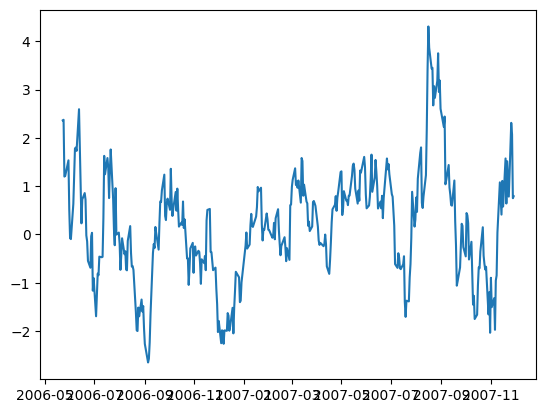

In [22]:
plt.plot(df.zscore)
plt.show()

In [13]:
sharpeTrainset

np.float64(2.121461424257659)

In [36]:
pnl.sum()

np.float64(nan)

In [14]:
sharpeTestset = np.sqrt(252) * np.mean(pnl[testset]) / np.std(pnl[testset])
sharpeTestset

np.float64(1.5000157724291203)

In [37]:
testset

array([252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
       304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
       330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383])

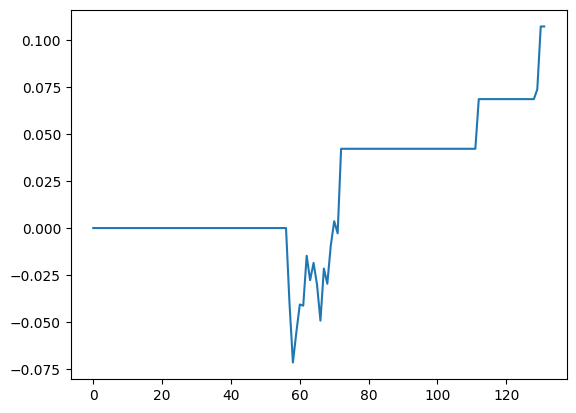

In [15]:
plt.plot(np.cumsum(pnl[testset])) 
# positions.to_pickle('example3_6_positions')